# FashionMNIST

<img src="https://emiliendupont.github.io/imgs/mnist-chicken/mnist-and-fashion-examples.png">

Будем работать с картинками одежды (чёрно-белыми, 28 на 28). По входной картинке нужно предсказать тип одежды на 10 классов.

In [8]:
!pip install wandb

In [9]:
# установим последнюю версию wandb
!pip install -q --upgrade wandb

In [10]:
import os
import wandb # для логирования

import numpy as np
import random
from tqdm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim # для оптимизаторов
from torchvision import datasets # для данных
import torchvision.transforms as transforms # для преобразований тензоров

import matplotlib.pyplot as plt

In [11]:
# Зафиксируем seed для воспроизводимости

def seed_everything(seed):
    random.seed(seed) # фиксируем генератор случайных чисел
    os.environ['PYTHONHASHSEED'] = str(seed) # фиксируем заполнения хешей
    np.random.seed(seed) # фиксируем генератор случайных чисел numpy
    torch.manual_seed(seed) # фиксируем генератор случайных чисел pytorch
    torch.cuda.manual_seed(seed) # фиксируем генератор случайных чисел для GPU
    #torch.backends.cudnn.deterministic = True # выбираем только детерминированные алгоритмы (для сверток)
    #torch.backends.cudnn.benchmark = False # фиксируем алгоритм вычисления сверток

Выпишем все классы для последующего использования. 

In [12]:
class CFG:

# Задаем параметры нашего эксперимента


  project = "DL_homework"
  entity = "Google"#
  num_epochs = 10 # количество эпох
  train_batch_size = 64 # размер батча обучающей выборки
  test_batch_size = 512 # размер батча тестовой выборки
  num_workers = 2 # количество активных процессов на загрузку данных
  lr = 0.001 # learning_rate
  seed = 2022 # для функции воспроизводимости
  wandb = False # флаг использования Wandb


In [13]:
# функция перевода класса конфигурации в словарь

def class2dict(f):
  return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

In [15]:
# будем загружать картинки, сразу преобразуя их в тензор и нормализуя

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.2859,), (0.3530,))])

Загружаем данные.

In [16]:
train_data = datasets.FashionMNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False,
                                  download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=CFG.train_batch_size,
                                          shuffle=True, num_workers=CFG.num_workers, pin_memory=True)

test_loader =  torch.utils.data.DataLoader(test_data, batch_size=CFG.test_batch_size,
                                         shuffle=False, num_workers=CFG.num_workers, pin_memory=True)

In [17]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples) # итерируемся по тестовым данным


In [18]:
batch_idx

0

In [19]:
example_data[0].shape

torch.Size([1, 28, 28])

In [20]:
example_data[0].view(-1, 28*28).shape

torch.Size([1, 784])

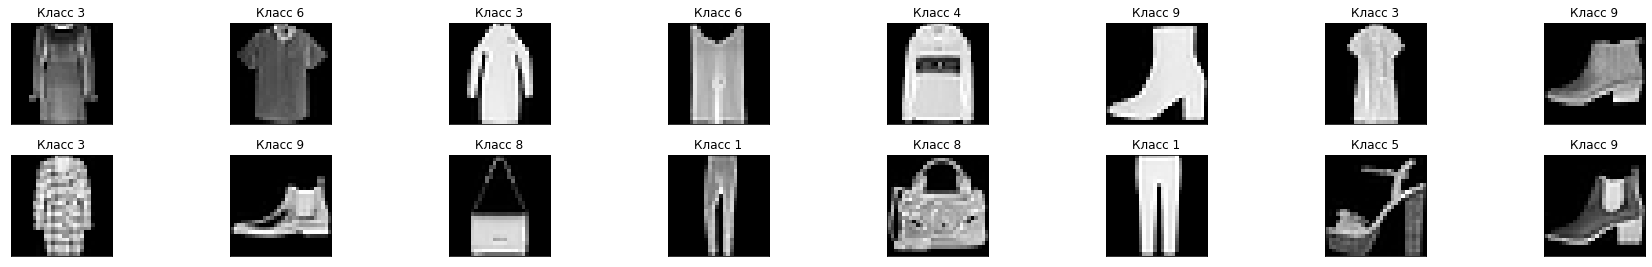

In [21]:

dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):

    plt.subplot(2,8,idx+1)
    plt.tight_layout()
    plt.imshow(example_data[idx][0], cmap='gray') 
    
    plt.title( 'Класс {}'.format(int(example_targets[idx])))
    plt.xticks([])
    plt.yticks([])
   # plt.figure()

Создаем полносвязаннную нейронную сеть. 

In [22]:
class My_Net(nn.Module): # наследуемся от класса nn.Module

    def __init__(self):
        super(My_Net,self).__init__()
        
        # количество нейронов в скрытых слоях (256, 128)
        self.hidden_1 = 256
        self.hidden_2 = 128
        # первый слой (784(=28*28) -> hidden_1)
        self.fc1 = nn.Linear(28*28, self.hidden_1) 
        # второй слой (hidden_1 -> hidden_2)
        self.fc2 = nn.Linear(self.hidden_1, self.hidden_2)
        # третий (выходной) слой (hidden_2 -> 10 (классов))
        self.fc3 = nn.Linear(self.hidden_2, 10)

        
    def forward(self, x):
        # преобразуем батч картинок из (N, 28, 28) в (N, 784)
        x = x.view(-1, 28*28)
        # добавляем первый скрытый слой с ReLU активацией
        x = F.relu(self.fc1(x))
        # добавляем второй скрытый слой с ReLU активацией
        x = F.relu(self.fc2(x))
        # добавляем третий (выходной) слой
        x = self.fc3(x)
        return x

In [23]:
model = My_Net()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device) # переводим модель на GPU
print(model) # посмотрим на модель

My_Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [24]:
# функция потерь (cross-entropy) для 10 классов
criterion = nn.CrossEntropyLoss()

# SGD (классический) со скоростью обучения (learning rate) = 0.01
optimizer = torch.optim.SGD(params=model.parameters(),
                           lr=0.01)

In [25]:
# функция обучения модели
def train(model, device, train_loader, optimizer, criterion, epoch, WANDB):
    model.train() # обязательно переводим в режим обучения
    test_loss = 0
    correct = 0
    
    n_ex = len(train_loader)
    
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=n_ex):
        data, target = data.to(device), target.to(device) # переводим картинки и таргеты на GPU
        # обнуляем градиенты!
        optimizer.zero_grad()
        # прямой проход
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item() # определяем корректность предсказания
        train_loss = criterion(output, target) # считаем значение функции потерь
        # обратный проход
        train_loss.backward()
        # делаем градиентный шаг оптимизатором
        optimizer.step()
        # считаем метрики и лосс
    tqdm.write('\nTrain set: Average loss: {:.4f}, Accuracy: {:.0f}%'.format(
        train_loss, 100. * correct / len(train_loader.dataset)))
    
    if WANDB:
        wandb.log({'train_loss': train_loss,
                   'train_accuracy': correct / len(train_loader.dataset)})

In [26]:
# функция тестирования
def test(model, device, test_loader, criterion, WANDB):
    model.eval() # переводем модель в режим инференса
    test_loss = 0
    correct = 0
    # показываем, что обученич нет и градиенты не обновляются
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss = criterion(output, target) # считаем значение функции потерь
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            # считаем метрики
    tqdm.write('Test set: Average loss: {:.4f}, Accuracy: {:.0f}%'.format(
        test_loss, 100. * correct / len(test_loader.dataset)))
    
    if WANDB:
        wandb.log({'test_loss': test_loss,
                   'test_accuracy': correct / len(test_loader.dataset)})

In [27]:
# основная функция для экспериментов
def main(model):
    # настраиваем окружение для wandb
    if CFG.wandb:
        os.environ["WANDB_API_KEY"] = CFG.api
        wandb.init(project=CFG.project, entity=CFG.entity, reinit=True, config=class2dict(CFG))
  
    use_cuda =torch.cuda.is_available() # проверяем доступность GPU 

    seed_everything(CFG.seed) # фиксируем сиды

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # выделили устройство  
    
    if CFG.wandb:
        wandb.watch(model, log='all') # логируем все (метрики, лоссы, градиенты)

    for epoch in range(1, CFG.num_epochs + 1): # цикл на эпохи
        print('\nEpoch:', epoch)
        train(model, device, train_loader, optimizer, criterion, epoch, CFG.wandb)
        test(model, device, test_loader, criterion, CFG.wandb)
    print('Training is end!')

In [28]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Thu Mar 30 17:35:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.65       Driver Version: 511.65       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P8    10W /  N/A |   1642MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Запускаем обучение.

In [29]:
main(model)


Epoch: 1


100%|██████████| 938/938 [00:25<00:00, 36.13it/s]



Train set: Average loss: 0.7031, Accuracy: 72%
Test set: Average loss: 0.5405, Accuracy: 78%

Epoch: 2


100%|██████████| 938/938 [00:20<00:00, 45.01it/s]



Train set: Average loss: 0.3137, Accuracy: 82%
Test set: Average loss: 0.4364, Accuracy: 82%

Epoch: 3


100%|██████████| 938/938 [00:19<00:00, 48.74it/s]



Train set: Average loss: 0.3606, Accuracy: 84%
Test set: Average loss: 0.4030, Accuracy: 83%

Epoch: 4


100%|██████████| 938/938 [00:19<00:00, 49.11it/s]



Train set: Average loss: 0.9046, Accuracy: 85%
Test set: Average loss: 0.3652, Accuracy: 84%

Epoch: 5


100%|██████████| 938/938 [00:17<00:00, 54.28it/s]



Train set: Average loss: 0.6019, Accuracy: 86%
Test set: Average loss: 0.3488, Accuracy: 84%

Epoch: 6


100%|██████████| 938/938 [00:18<00:00, 49.45it/s]



Train set: Average loss: 0.1744, Accuracy: 86%
Test set: Average loss: 0.3200, Accuracy: 85%

Epoch: 7


100%|██████████| 938/938 [00:20<00:00, 46.69it/s]



Train set: Average loss: 0.3283, Accuracy: 87%
Test set: Average loss: 0.3318, Accuracy: 85%

Epoch: 8


100%|██████████| 938/938 [00:17<00:00, 53.62it/s]



Train set: Average loss: 0.2837, Accuracy: 88%
Test set: Average loss: 0.2969, Accuracy: 86%

Epoch: 9


100%|██████████| 938/938 [00:17<00:00, 53.46it/s]



Train set: Average loss: 0.2791, Accuracy: 88%
Test set: Average loss: 0.2889, Accuracy: 86%

Epoch: 10


100%|██████████| 938/938 [00:17<00:00, 54.03it/s]



Train set: Average loss: 0.4397, Accuracy: 88%
Test set: Average loss: 0.2859, Accuracy: 86%
Training is end!


Пробуем другие оптимизаторы.

In [22]:
# Adam со скоростью обучения (learning rate) = 0.001
optimizer = torch.optim.Adam(params=model.parameters(),
                           lr=0.001)

In [23]:
main(model)


Epoch: 1


100%|██████████| 938/938 [00:18<00:00, 51.77it/s]



Train set: Average loss: 0.3257, Accuracy: 85%
Test set: Average loss: 0.3197, Accuracy: 84%

Epoch: 2


100%|██████████| 938/938 [00:22<00:00, 42.41it/s]



Train set: Average loss: 0.1427, Accuracy: 88%
Test set: Average loss: 0.2781, Accuracy: 87%

Epoch: 3


100%|██████████| 938/938 [00:22<00:00, 41.34it/s]



Train set: Average loss: 0.1612, Accuracy: 89%
Test set: Average loss: 0.2938, Accuracy: 86%

Epoch: 4


100%|██████████| 938/938 [00:21<00:00, 42.85it/s]



Train set: Average loss: 0.5043, Accuracy: 90%
Test set: Average loss: 0.2577, Accuracy: 87%

Epoch: 5


100%|██████████| 938/938 [00:21<00:00, 42.66it/s]


Train set: Average loss: 0.5338, Accuracy: 90%


Test set: Average loss: 0.2954, Accuracy: 87%

Epoch: 6


100%|██████████| 938/938 [00:19<00:00, 48.47it/s]



Train set: Average loss: 0.0958, Accuracy: 91%
Test set: Average loss: 0.2440, Accuracy: 88%

Epoch: 7


100%|██████████| 938/938 [00:20<00:00, 44.93it/s]



Train set: Average loss: 0.2396, Accuracy: 91%
Test set: Average loss: 0.2644, Accuracy: 88%

Epoch: 8


100%|██████████| 938/938 [00:19<00:00, 47.03it/s]



Train set: Average loss: 0.1998, Accuracy: 92%
Test set: Average loss: 0.2233, Accuracy: 89%

Epoch: 9


100%|██████████| 938/938 [00:18<00:00, 50.03it/s]



Train set: Average loss: 0.0873, Accuracy: 92%
Test set: Average loss: 0.2691, Accuracy: 88%

Epoch: 10


100%|██████████| 938/938 [00:17<00:00, 54.66it/s]



Train set: Average loss: 0.3088, Accuracy: 92%
Test set: Average loss: 0.2361, Accuracy: 89%
Training is end!


In [24]:
# Adam со скоростью обучения (learning rate) = 0.001
optimizer = torch.optim.Adadelta(params=model.parameters(),
                           lr=1.0)

In [25]:
main(model)


Epoch: 1


100%|██████████| 938/938 [00:20<00:00, 45.26it/s]



Train set: Average loss: 0.0839, Accuracy: 92%
Test set: Average loss: 0.2774, Accuracy: 87%

Epoch: 2


100%|██████████| 938/938 [00:19<00:00, 47.25it/s]



Train set: Average loss: 0.0629, Accuracy: 92%
Test set: Average loss: 0.3783, Accuracy: 88%

Epoch: 3


100%|██████████| 938/938 [00:16<00:00, 56.43it/s]



Train set: Average loss: 0.1289, Accuracy: 92%
Test set: Average loss: 0.3088, Accuracy: 89%

Epoch: 4


100%|██████████| 938/938 [00:18<00:00, 51.21it/s]



Train set: Average loss: 0.4131, Accuracy: 92%
Test set: Average loss: 0.3975, Accuracy: 85%

Epoch: 5


100%|██████████| 938/938 [00:17<00:00, 54.36it/s]



Train set: Average loss: 0.6842, Accuracy: 93%
Test set: Average loss: 0.3416, Accuracy: 86%

Epoch: 6


100%|██████████| 938/938 [00:16<00:00, 56.24it/s]



Train set: Average loss: 0.0483, Accuracy: 93%
Test set: Average loss: 0.3676, Accuracy: 88%

Epoch: 7


100%|██████████| 938/938 [00:16<00:00, 56.00it/s]



Train set: Average loss: 0.3080, Accuracy: 93%
Test set: Average loss: 0.3915, Accuracy: 88%

Epoch: 8


100%|██████████| 938/938 [00:18<00:00, 50.36it/s]



Train set: Average loss: 0.2547, Accuracy: 93%
Test set: Average loss: 0.4383, Accuracy: 88%

Epoch: 9


100%|██████████| 938/938 [00:16<00:00, 56.16it/s]



Train set: Average loss: 0.0597, Accuracy: 93%
Test set: Average loss: 0.4908, Accuracy: 88%

Epoch: 10


100%|██████████| 938/938 [00:16<00:00, 56.17it/s]



Train set: Average loss: 0.1963, Accuracy: 93%
Test set: Average loss: 0.3071, Accuracy: 87%
Training is end!


Оптимизатор Adam продемонстировал лучший результат среди SGD and Adadeta. 
Train set: Average loss: 0.3088, Accuracy: 92%
Test set: Average loss: 0.2361, Accuracy: 89%

In [26]:
class My_Net_Extended(nn.Module): # наследуемся от класса nn.Module

    def __init__(self):
        super(My_Net_Extended,self).__init__()
        
        # количество нейронов в скрытых слоях (256, 128, 64)
        self.hidden_1 = 256
        self.hidden_2 = 128
        self.hidden_3 = 64
        # первый слой (784(=28*28) -> hidden_1)
        self.fc1 = nn.Linear(28*28, self.hidden_1) 
        # второй слой (hidden_1 -> hidden_2)
        self.fc2 = nn.Linear(self.hidden_1, self.hidden_2)
        # третий ( (hidden_2 -> hidden_3)
        self.fc3 = nn.Linear(self.hidden_2, self.hidden_3)
        # четвертый (выходной) слой (hidden_3 -> 10 (классов))
        self.fc4 = nn.Linear(self.hidden_3, 10)

        
    def forward(self, x):
        # преобразуем батч картинок из (N, 28, 28) в (N, 784)
        x = x.view(-1, 28*28)
        # добавляем первый скрытый слой с ReLU активацией
        x = F.relu(self.fc1(x))
        # добавляем второй скрытый слой с ReLU активацией
        x = F.relu(self.fc2(x))
        # добавляем третий скрытый слой с ReLU активацией
        x = F.relu(self.fc3(x))
        # добавляем третий (выходной) слой
        x = self.fc4(x)
        return x

In [34]:
model = My_Net_Extended()

In [35]:
optimizer = torch.optim.Adam(params=model.parameters(),
                           lr=0.001)

In [36]:
model = model.to(device) # переводим модель на GPU

In [37]:
main(model)


Epoch: 1


100%|██████████| 938/938 [00:20<00:00, 46.75it/s]



Train set: Average loss: 0.3070, Accuracy: 82%
Test set: Average loss: 0.3369, Accuracy: 84%

Epoch: 2


100%|██████████| 938/938 [00:17<00:00, 53.73it/s]



Train set: Average loss: 0.1899, Accuracy: 87%
Test set: Average loss: 0.2602, Accuracy: 86%

Epoch: 3


100%|██████████| 938/938 [00:17<00:00, 53.40it/s]



Train set: Average loss: 0.1840, Accuracy: 88%
Test set: Average loss: 0.2975, Accuracy: 85%

Epoch: 4


100%|██████████| 938/938 [00:17<00:00, 52.16it/s]



Train set: Average loss: 0.4196, Accuracy: 89%
Test set: Average loss: 0.2283, Accuracy: 87%

Epoch: 5


100%|██████████| 938/938 [00:20<00:00, 46.62it/s]



Train set: Average loss: 0.4718, Accuracy: 90%
Test set: Average loss: 0.2246, Accuracy: 87%

Epoch: 6


100%|██████████| 938/938 [00:21<00:00, 43.90it/s]



Train set: Average loss: 0.0417, Accuracy: 90%
Test set: Average loss: 0.2094, Accuracy: 88%

Epoch: 7


100%|██████████| 938/938 [00:22<00:00, 41.35it/s]



Train set: Average loss: 0.2450, Accuracy: 91%
Test set: Average loss: 0.2186, Accuracy: 88%

Epoch: 8


100%|██████████| 938/938 [00:20<00:00, 45.24it/s]



Train set: Average loss: 0.2089, Accuracy: 91%
Test set: Average loss: 0.2016, Accuracy: 89%

Epoch: 9


100%|██████████| 938/938 [00:18<00:00, 51.78it/s]



Train set: Average loss: 0.1306, Accuracy: 92%
Test set: Average loss: 0.2343, Accuracy: 89%

Epoch: 10


100%|██████████| 938/938 [00:17<00:00, 53.80it/s]



Train set: Average loss: 0.3477, Accuracy: 92%
Test set: Average loss: 0.2219, Accuracy: 89%
Training is end!


In [40]:
class My_Net_Extended_V2(nn.Module): # наследуемся от класса nn.Module

    def __init__(self):
        super(My_Net_Extended_V2,self).__init__()
        
        # количество нейронов в скрытых слоях (256, 128, 128)
        self.hidden_1 = 256
        self.hidden_2 = 128
        self.hidden_3 = 128

        # первый слой (784(=28*28) -> hidden_1)
        self.fc1 = nn.Linear(28*28, self.hidden_1) 
        # второй слой (hidden_1 -> hidden_2)
        self.fc2 = nn.Linear(self.hidden_1, self.hidden_2)
        # третий ( (hidden_2 -> hidden_3)
        self.fc3 = nn.Linear(self.hidden_2, self.hidden_3)
        # четвертый (выходной) слой (hidden_3 -> 10 (классов))
        self.fc4 = nn.Linear(self.hidden_3, 10)

        
    def forward(self, x):
        # преобразуем батч картинок из (N, 28, 28) в (N, 784)
        x = x.view(-1, 28*28)
        # добавляем первый скрытый слой с ReLU активацией
        x = F.relu(self.fc1(x))
        # добавляем второй скрытый слой с ReLU активацией
        x = F.relu(self.fc2(x))
        # добавляем третий скрытый слой с ReLU активацией
        x = F.relu(self.fc3(x))
        # добавляем третий (выходной) слой
        x = self.fc4(x)
        return x

In [41]:
model = My_Net_Extended_V2()

optimizer = torch.optim.Adam(params=model.parameters(),
                           lr=0.001)

model = model.to(device) # переводим модель на GPU

In [42]:
main(model)


Epoch: 1


100%|██████████| 938/938 [00:20<00:00, 45.57it/s]



Train set: Average loss: 0.3806, Accuracy: 82%
Test set: Average loss: 0.3269, Accuracy: 85%

Epoch: 2


100%|██████████| 938/938 [00:20<00:00, 45.13it/s]



Train set: Average loss: 0.1557, Accuracy: 87%
Test set: Average loss: 0.2658, Accuracy: 86%

Epoch: 3


100%|██████████| 938/938 [00:18<00:00, 50.03it/s]



Train set: Average loss: 0.1956, Accuracy: 88%
Test set: Average loss: 0.2925, Accuracy: 86%

Epoch: 4


100%|██████████| 938/938 [00:17<00:00, 52.96it/s]



Train set: Average loss: 0.5303, Accuracy: 89%
Test set: Average loss: 0.2173, Accuracy: 87%

Epoch: 5


100%|██████████| 938/938 [00:17<00:00, 53.10it/s]



Train set: Average loss: 0.5245, Accuracy: 90%
Test set: Average loss: 0.2278, Accuracy: 88%

Epoch: 6


100%|██████████| 938/938 [00:17<00:00, 52.54it/s]



Train set: Average loss: 0.0580, Accuracy: 90%
Test set: Average loss: 0.2135, Accuracy: 88%

Epoch: 7


100%|██████████| 938/938 [00:17<00:00, 52.98it/s]



Train set: Average loss: 0.2261, Accuracy: 91%
Test set: Average loss: 0.2567, Accuracy: 88%

Epoch: 8


100%|██████████| 938/938 [00:17<00:00, 54.78it/s]



Train set: Average loss: 0.2376, Accuracy: 91%
Test set: Average loss: 0.2340, Accuracy: 88%

Epoch: 9


100%|██████████| 938/938 [00:16<00:00, 55.45it/s]



Train set: Average loss: 0.0800, Accuracy: 92%
Test set: Average loss: 0.2339, Accuracy: 89%

Epoch: 10


100%|██████████| 938/938 [00:16<00:00, 55.43it/s]



Train set: Average loss: 0.3551, Accuracy: 92%
Test set: Average loss: 0.2093, Accuracy: 89%
Training is end!


модели с количеством нейронов в скрытых слоях (256, 128, 128), (256, 128), (256, 128, 64) и оптимизатором Adam показали идентичные результаты
Train set: Average loss: 0.3551, Accuracy: 92%
Test set: Average loss: 0.2093, Accuracy: 89%

In [43]:
class My_Net_Extended_V3(nn.Module): # наследуемся от класса nn.Module

    def __init__(self):
        super(My_Net_Extended_V3,self).__init__()
        
        # количество нейронов в скрытых слоях (256, 128, 128, 64, 43)
        self.hidden_1 = 256
        self.hidden_2 = 128
        self.hidden_3 = 128
        self.hidden_4 = 64
        self.hidden_5 = 32
        # первый слой (784(=28*28) -> hidden_1)
        self.fc1 = nn.Linear(28*28, self.hidden_1) 
        # второй слой (hidden_1 -> hidden_2)
        self.fc2 = nn.Linear(self.hidden_1, self.hidden_2)
        # третий ( (hidden_2 -> hidden_3)
        self.fc3 = nn.Linear(self.hidden_2, self.hidden_3)
        #четвертый
        self.fc4 = nn.Linear(self.hidden_3, self.hidden_4)
        #пятый
        self.fc5 = nn.Linear(self.hidden_4, self.hidden_5)
        # шестой (выходной) слой (hidden_5 -> 10 (классов))
        self.fc6 = nn.Linear(self.hidden_5, 10)

        
    def forward(self, x):
        # преобразуем батч картинок из (N, 28, 28) в (N, 784)
        x = x.view(-1, 28*28)
        # добавляем первый скрытый слой с ReLU активацией
        x = F.relu(self.fc1(x))
        # добавляем второй скрытый слой с ReLU активацией
        x = F.relu(self.fc2(x))
        # добавляем третий скрытый слой с ReLU активацией
        x = F.relu(self.fc3(x))
        # добавляем четвертый скрытый слой с ReLU активацией
        x = F.relu(self.fc4(x))
        # добавляем пятый скрытый слой с ReLU активацией
        x = F.relu(self.fc5(x))
        # добавляем шесто (выходной) слой
        x = self.fc6(x)
        return x

In [44]:
model = My_Net_Extended_V3()

In [47]:

optimizer = torch.optim.Adam(params=model.parameters(),
                           lr=0.001)

model = model.to(device) # переводим модель на GPU

In [48]:
main(model)


Epoch: 1


100%|██████████| 938/938 [00:18<00:00, 49.82it/s]



Train set: Average loss: 0.3556, Accuracy: 80%
Test set: Average loss: 0.4096, Accuracy: 83%

Epoch: 2


100%|██████████| 938/938 [00:18<00:00, 51.08it/s]



Train set: Average loss: 0.1621, Accuracy: 86%
Test set: Average loss: 0.3134, Accuracy: 86%

Epoch: 3


100%|██████████| 938/938 [00:18<00:00, 49.91it/s]



Train set: Average loss: 0.2032, Accuracy: 88%
Test set: Average loss: 0.3050, Accuracy: 85%

Epoch: 4


100%|██████████| 938/938 [00:19<00:00, 48.10it/s]



Train set: Average loss: 0.5795, Accuracy: 89%
Test set: Average loss: 0.2569, Accuracy: 87%

Epoch: 5


100%|██████████| 938/938 [00:19<00:00, 47.35it/s]



Train set: Average loss: 0.4872, Accuracy: 89%
Test set: Average loss: 0.2614, Accuracy: 88%

Epoch: 6


100%|██████████| 938/938 [00:19<00:00, 47.58it/s]



Train set: Average loss: 0.0978, Accuracy: 90%
Test set: Average loss: 0.2370, Accuracy: 88%

Epoch: 7


100%|██████████| 938/938 [00:19<00:00, 47.22it/s]



Train set: Average loss: 0.2596, Accuracy: 90%
Test set: Average loss: 0.2462, Accuracy: 88%

Epoch: 8


100%|██████████| 938/938 [00:19<00:00, 49.00it/s]



Train set: Average loss: 0.2041, Accuracy: 91%
Test set: Average loss: 0.2361, Accuracy: 88%

Epoch: 9


100%|██████████| 938/938 [00:18<00:00, 50.25it/s]



Train set: Average loss: 0.0764, Accuracy: 91%
Test set: Average loss: 0.2576, Accuracy: 89%

Epoch: 10


100%|██████████| 938/938 [00:20<00:00, 46.52it/s]



Train set: Average loss: 0.2856, Accuracy: 92%
Test set: Average loss: 0.2234, Accuracy: 89%
Training is end!


нейронная сеть из 5 скрытых слоев (256, 128, 128, 64, 43) показал идентичный результат как и сеть из 2 скрытых слоев (256, 128)